In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

from dyck_k_generator import constants

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device

'cuda:0'

In [4]:
if device == "mps":
    torch.mps.empty_cache()
elif device == "cuda:0":
    torch.cuda.empty_cache()

In [5]:
k = 1

In [6]:
from dyck_k_generator.generator import generate_dataset

generate_dataset(
    n=10_000,
    k=k,
    max_length=10,
    balanced=0.6,
)

Generating unbalanced strings: 100%|██████████| 4000/4000 [00:00<00:00, 74345.67it/s]
Saving dataset to data/dyck-1_10000-samples_10-len_p06.jsonl: 100%|██████████| 10000/10000 [00:00<00:00, 617526.83it/s]

Dataset saved to data/dyck-1_10000-samples_10-len_p06.jsonl


'data/dyck-1_10000-samples_10-len_p06.jsonl'

In [7]:
VOCAB = "".join(["".join((key, value)) for key, value in list(constants.BRACKETS.items())[:k]])
VOCAB

'()'

In [8]:
from dataset.dataset import DyckLanguageDataset

In [9]:
dataset = DyckLanguageDataset("data/dyck-1_500000-samples_8-len_p05.jsonl", VOCAB).to(device)

Loaded 500000 samples from data/dyck-1_500000-samples_8-len_p05.jsonl


Tokenizing strings: 100%|██████████| 500000/500000 [00:00<00:00, 524969.41it/s]


In [10]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = int(0.15 * train_size)
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [11]:
from torch.utils.data import DataLoader

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Manual Transformer + BERTViz


In [13]:
from transformer.hooked_transformer import (
    TransformerClassifier,
    TransformerClassifierConfig,
    pad_token_mask,
)

In [15]:
model_config = TransformerClassifierConfig(
    vocab_size=len(VOCAB),
    d_model=128,
    n_heads=1,
    dim_ff=256,
    n_layers=1,
    n_classes=2,
    max_seq_len=8,
)

In [16]:
model = TransformerClassifier(model_config)

In [17]:
model.to(device)

TransformerClassifier(
  (embedding): Embedding(5, 128)
  (pos_encoder): PositionalEncoder(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): EncoderBlock(
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=128, out_features=128, bias=True)
          (k_linear): Linear(in_features=128, out_features=128, bias=True)
          (v_linear): Linear(in_features=128, out_features=128, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (residual_dropout): Dropout(p=0.1, inplace=False)
          (attn): ScaledDotProductAttention()
          (out): Linear(in_features=128, out_features=128, bias=True)
        )
        (ff): Sequential(
          (0): Linear(in_features=128, out_features=256, bias=True)
          (1): Dropout(p=0.1, inplace=False)
          (2): ReLU(inplace=True)
          (3): Linear(in_features=256, out_features=128, bias=True)
        )
        (ln1): La

In [18]:
import torch.optim as optim

crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [19]:
train_loss, train_acc, val_loss, val_acc = model.train_model(
    device=device,
    epochs=5,
    optimizer=optimizer,
    criterion=crit,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    use_mask=True,
)

Epoch 1/5


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 2314.5876 | Train Acc: 74.86%
Val Loss: 650.2207 | Val Acc: 50.14%
Epoch 2/5


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 3652.5658 | Train Acc: 57.99%
Val Loss: 0.2065 | Val Acc: 100.00%
Epoch 3/5


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.4409 | Train Acc: 100.00%
Val Loss: 0.0025 | Val Acc: 100.00%
Epoch 4/5


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.0098 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%
Epoch 5/5


  0%|          | 0/6250 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Train Loss: 0.0003 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%


In [20]:
test_loss, test_acc = model.eval_model(
    device=device,
    test_dataloader=test_dataloader,
    criterion=crit,
    use_mask=True,
)

  0%|          | 0/5000 [00:00<?, ?it/s]

Test Loss: 0.0000 | Test Acc: 100.00%


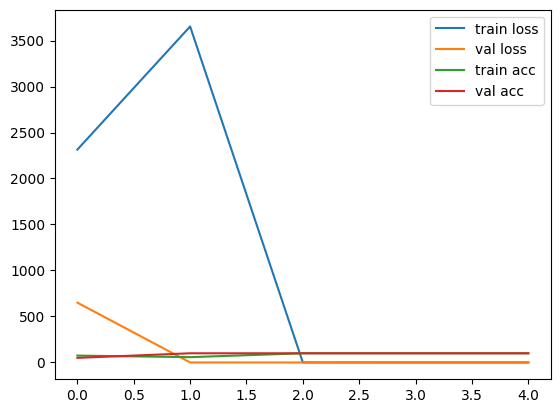

In [21]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.plot(train_acc, label="train acc")
plt.plot(val_acc, label="val acc")
plt.legend()
plt.show()

# Attention plots:


In [123]:
batch = next(iter(test_dataloader))
strings, labels, tokens = batch

mask = pad_token_mask(tokens)
attn_matrices = model.get_attn_matrices(tokens, mask)

In [158]:
from transformer_viz.visualizer import min_max_normalize, plot_attn_matrices

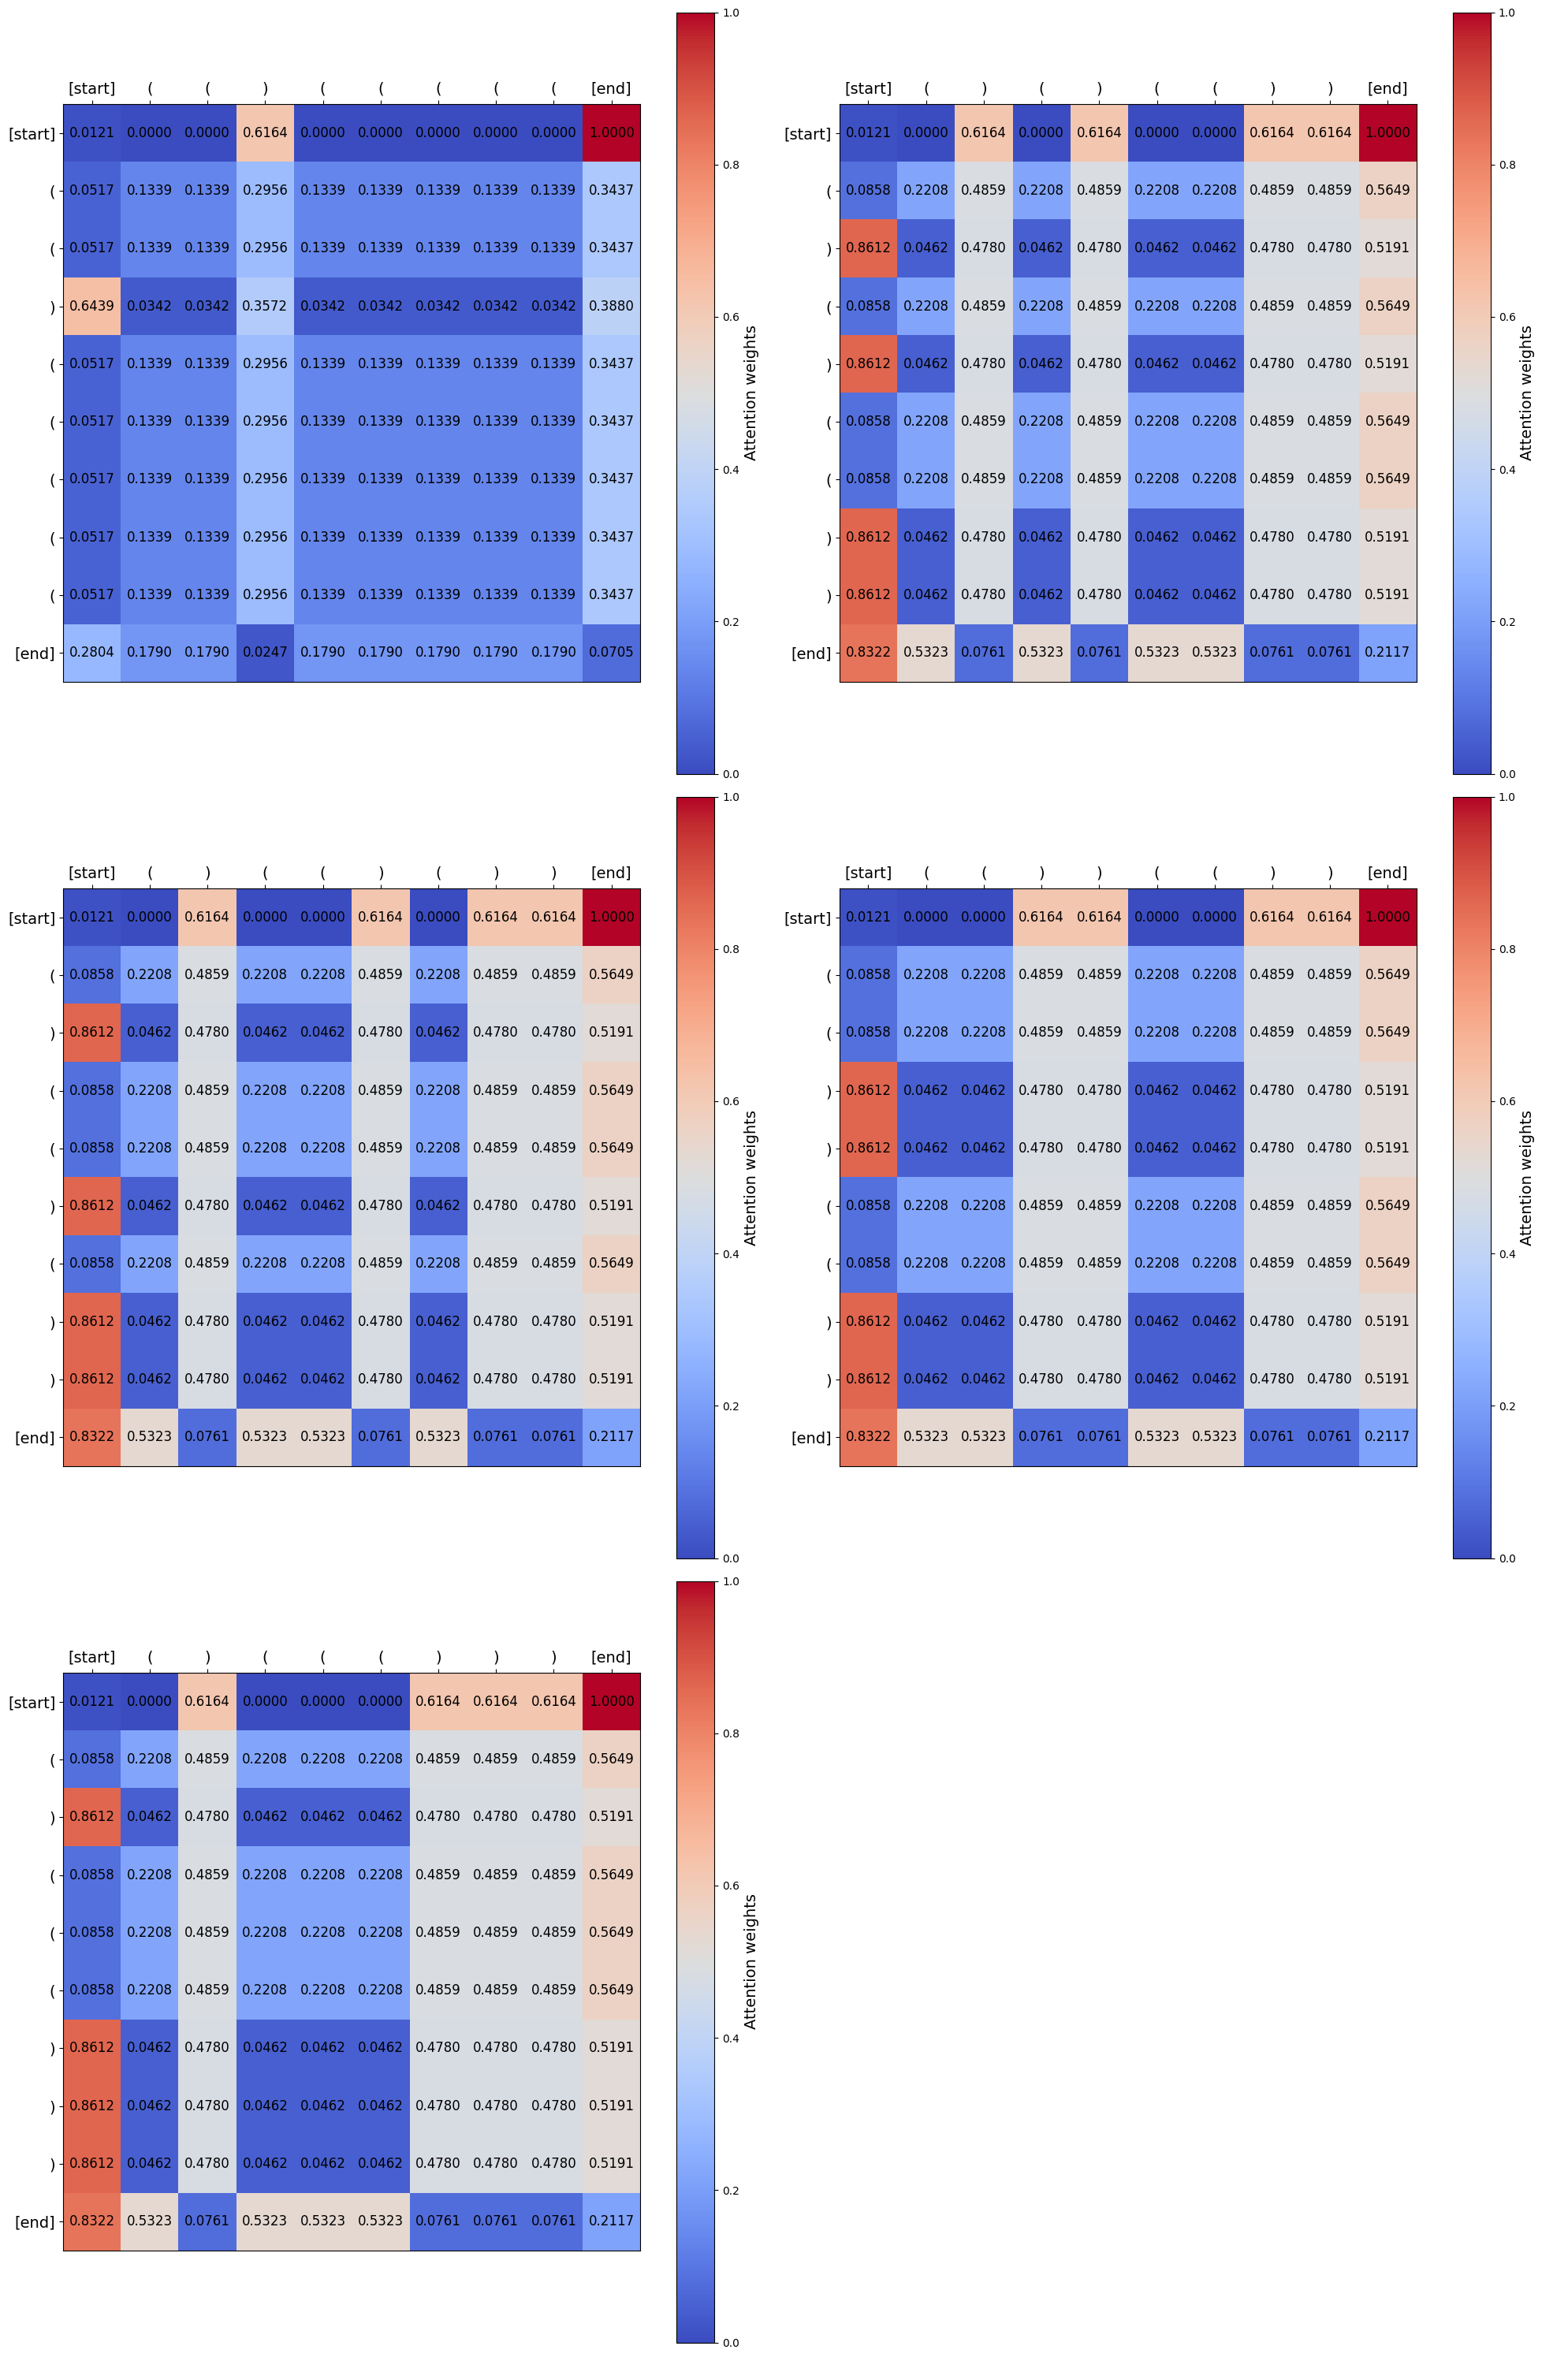

In [161]:
plot_attn_matrices(VOCAB, batch, model, min_max_normalize, pad_token_mask)

In [97]:
minimax_norm = min_max_normalize(attn_matrices[0][0][0].cpu().detach().numpy())

In [120]:
minimax_norm[0][0]

0.012053897

# Experiment 2


In [164]:
k = 3

In [165]:
path = generate_dataset(
    n=10_000,
    k=3,
    min_length=8,
    max_length=8,
    balanced=0.6,
)

Generating unbalanced strings: 100%|██████████| 4000/4000 [00:00<00:00, 48087.96it/s]
Saving dataset to data/dyck-3_10000-samples_8-len_p06.jsonl: 100%|██████████| 10000/10000 [00:00<00:00, 616782.20it/s]

Dataset saved to data/dyck-3_10000-samples_8-len_p06.jsonl


In [166]:
VOCAB = "".join(["".join((key, value)) for key, value in list(constants.BRACKETS.items())[:k]])
VOCAB

'()[]{}'

In [167]:
dataset_dyck_2 = DyckLanguageDataset(path, VOCAB).to(device)

Loaded 10000 samples from data/dyck-3_10000-samples_8-len_p06.jsonl


Tokenizing strings: 100%|██████████| 10000/10000 [00:00<00:00, 602924.42it/s]


In [192]:
train_size = int(0.8 * len(dataset_dyck_2))
val_size = int(0.15 * train_size)
test_size = len(dataset_dyck_2) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset_dyck_2, [train_size, val_size, test_size])

In [193]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [194]:
model_config = TransformerClassifierConfig(
    vocab_size=len(VOCAB),
    d_model=512,
    n_heads=1,
    dim_ff=1024,
    n_layers=1,
    n_classes=2,
    max_seq_len=8,
)

In [195]:
model = TransformerClassifier(model_config).to(device)

In [206]:
crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [207]:
train_loss, train_acc, val_loss, val_acc = model.train_model(
    device=device,
    epochs=15,
    optimizer=optimizer,
    criterion=crit,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    use_mask=True,
)

Epoch 1/15


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 5.0967 | Train Acc: 99.17%
Val Loss: 0.8301 | Val Acc: 99.08%
Epoch 2/15


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 5.0684 | Train Acc: 99.17%
Val Loss: 0.8295 | Val Acc: 99.08%
Epoch 3/15


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 5.0483 | Train Acc: 99.17%
Val Loss: 0.8287 | Val Acc: 99.08%
Epoch 4/15


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 5.0676 | Train Acc: 99.17%
Val Loss: 0.8310 | Val Acc: 99.08%
Epoch 5/15


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 5.0724 | Train Acc: 99.17%
Val Loss: 0.8295 | Val Acc: 99.08%
Epoch 6/15


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 5.0535 | Train Acc: 99.17%
Val Loss: 0.8302 | Val Acc: 99.08%
Epoch 7/15


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 5.0634 | Train Acc: 99.17%
Val Loss: 0.8289 | Val Acc: 99.08%
Epoch 8/15


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 5.0659 | Train Acc: 99.17%
Val Loss: 0.8290 | Val Acc: 99.08%
Epoch 9/15


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 5.0786 | Train Acc: 99.17%
Val Loss: 0.8277 | Val Acc: 99.08%
Epoch 10/15


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 5.0872 | Train Acc: 99.17%
Val Loss: 0.8281 | Val Acc: 99.08%
Epoch 11/15


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 5.0567 | Train Acc: 99.17%
Val Loss: 0.8294 | Val Acc: 99.08%
Epoch 12/15


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 5.0618 | Train Acc: 99.17%
Val Loss: 0.8296 | Val Acc: 99.08%
Epoch 13/15


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 5.0445 | Train Acc: 99.17%
Val Loss: 0.8284 | Val Acc: 99.08%
Epoch 14/15


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 5.0813 | Train Acc: 99.17%
Val Loss: 0.8295 | Val Acc: 99.08%
Epoch 15/15


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 5.0797 | Train Acc: 99.17%
Val Loss: 0.8278 | Val Acc: 99.08%


In [208]:
test_loss, test_acc = model.eval_model(
    device=device,
    test_dataloader=test_dataloader,
    criterion=crit,
    use_mask=True,
)

  0%|          | 0/100 [00:00<?, ?it/s]

Test Loss: 1.7109 | Test Acc: 99.75%


In [203]:
batch = next(iter(test_dataloader))
batch

[('[]()({})',
  '}((}[)))',
  '{{{[]}}}',
  '[[{{}}]]',
  '((({})))',
  '}((}[)))',
  '{}[]{}()',
  '}((}[)))'),
 tensor([1., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0'),
 tensor([[0., 5., 6., 3., 4., 3., 7., 8., 4., 2.],
         [0., 8., 3., 3., 8., 5., 4., 4., 4., 2.],
         [0., 7., 7., 7., 5., 6., 8., 8., 8., 2.],
         [0., 5., 5., 7., 7., 8., 8., 6., 6., 2.],
         [0., 3., 3., 3., 7., 8., 4., 4., 4., 2.],
         [0., 8., 3., 3., 8., 5., 4., 4., 4., 2.],
         [0., 7., 8., 5., 6., 7., 8., 3., 4., 2.],
         [0., 8., 3., 3., 8., 5., 4., 4., 4., 2.]], device='cuda:0')]

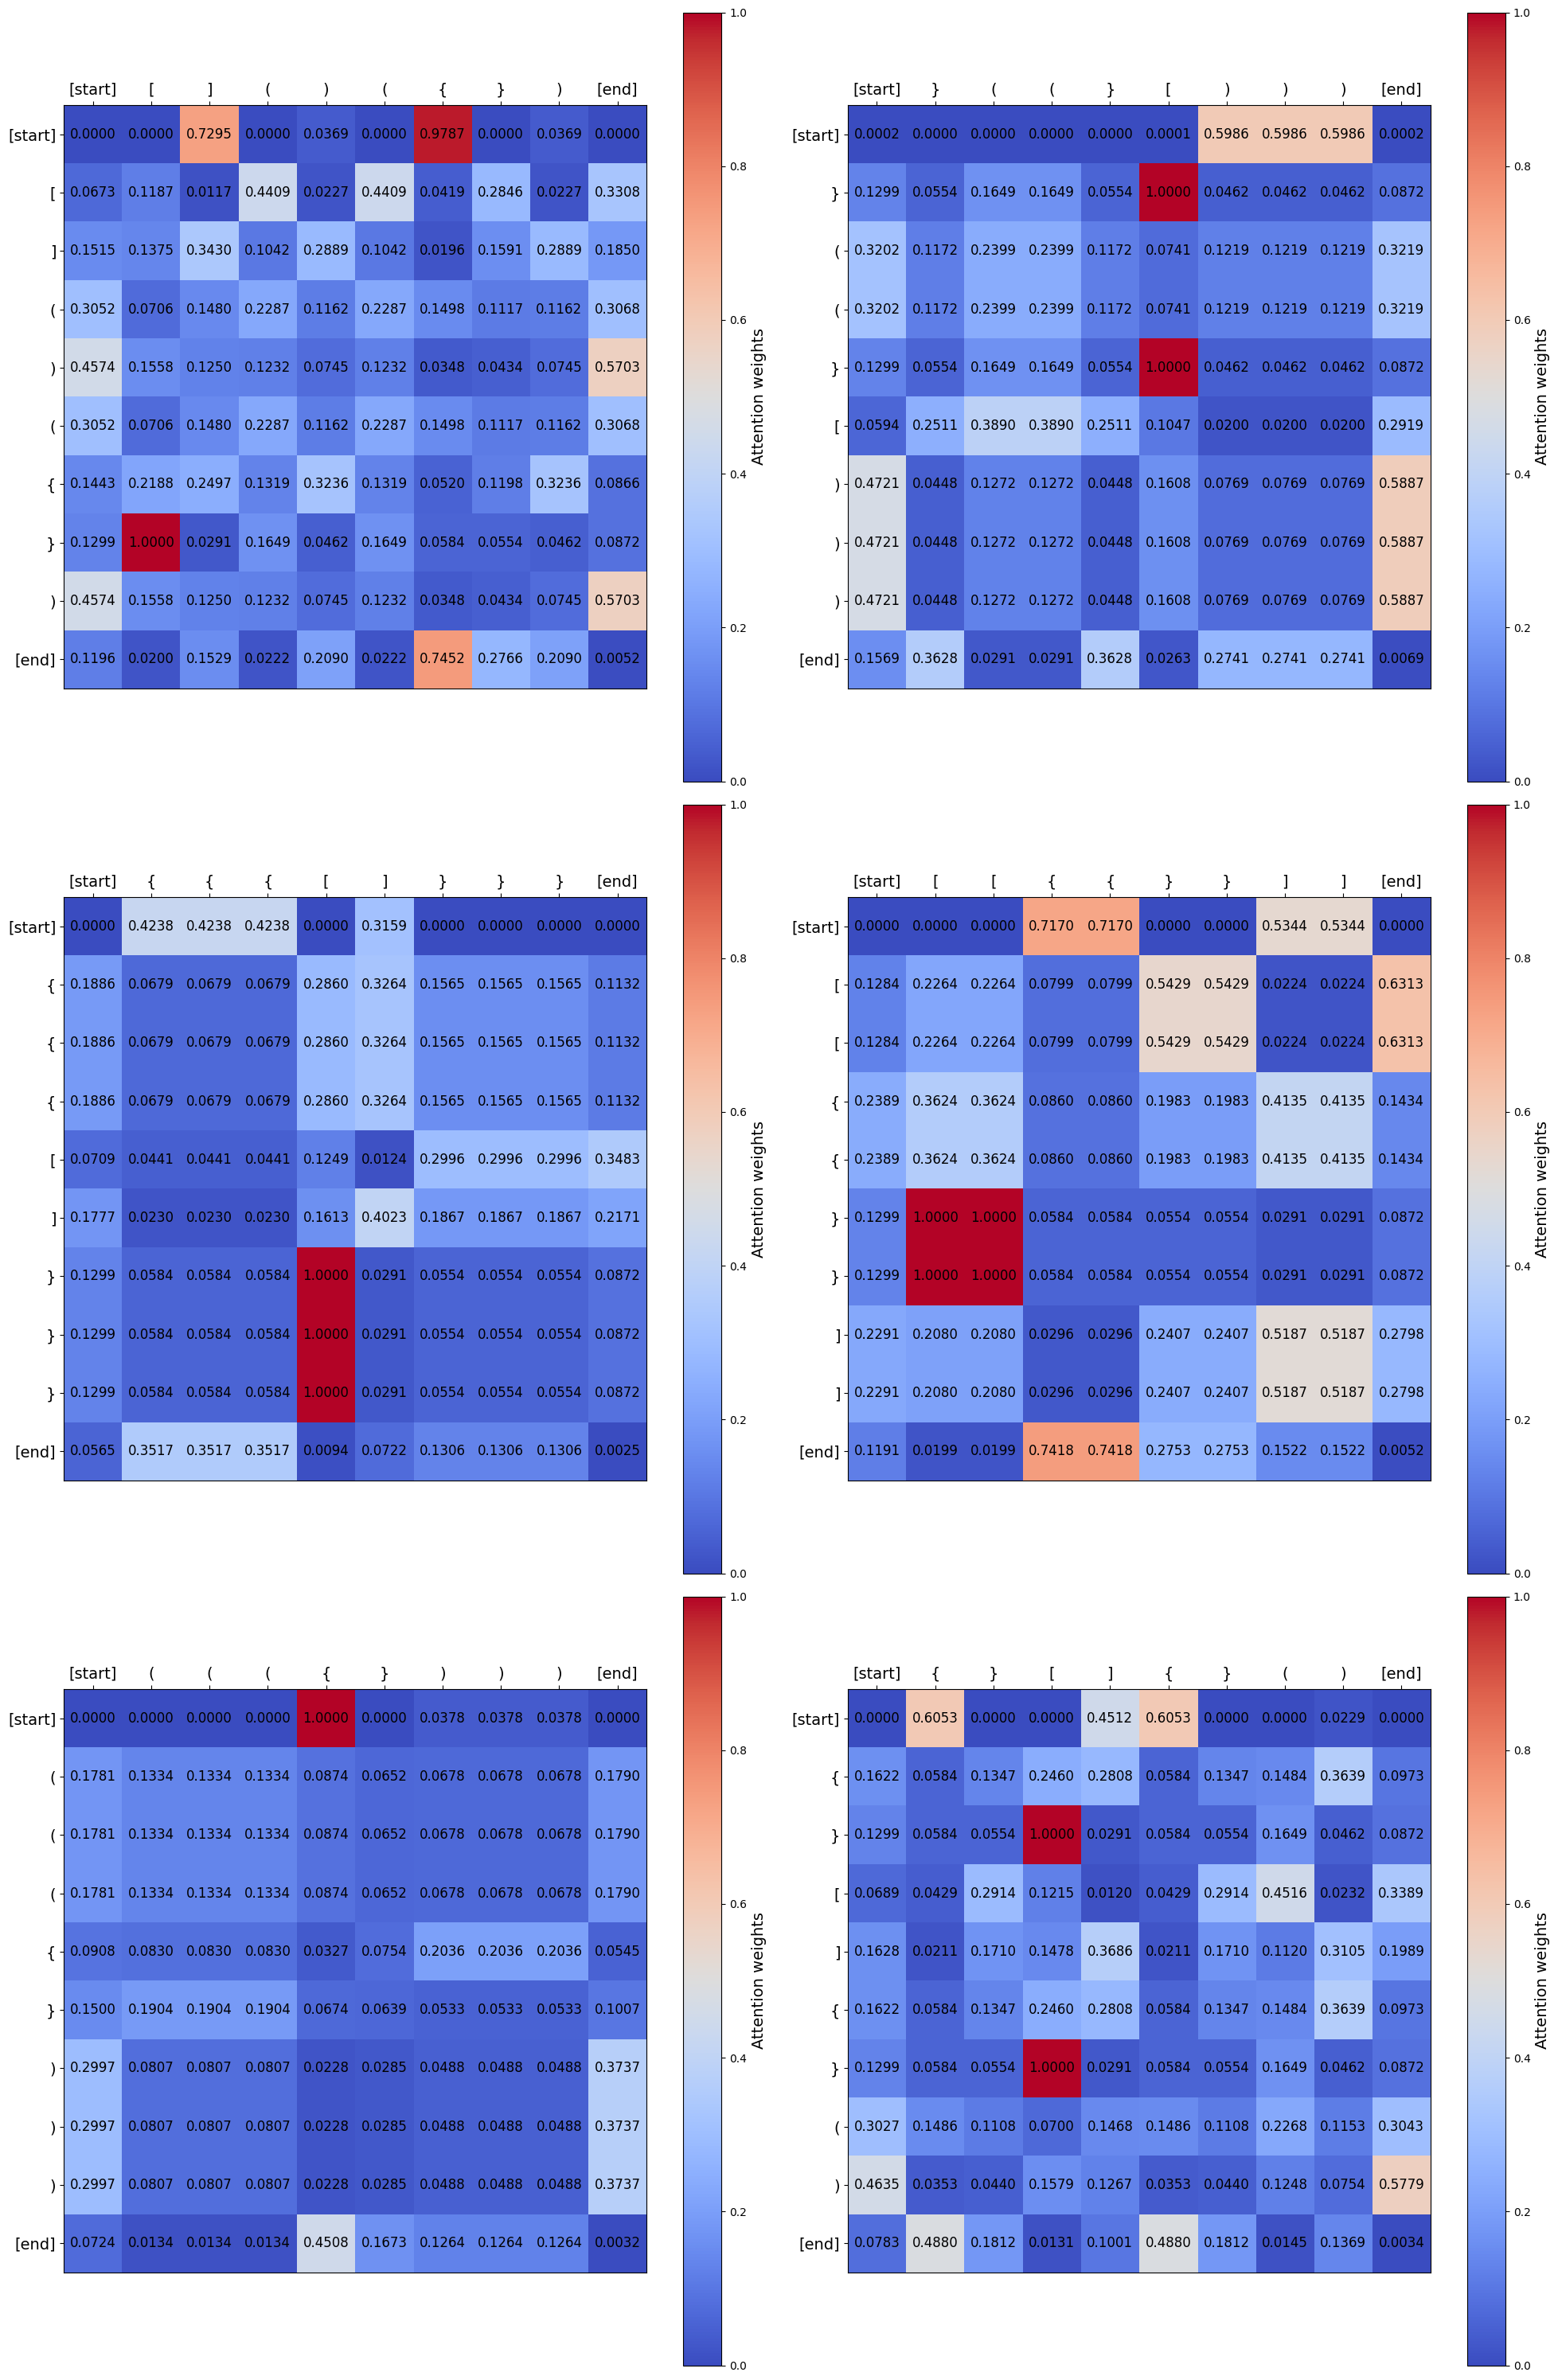

In [204]:
plot_attn_matrices(VOCAB, batch, model, min_max_normalize, pad_token_mask)